# Практическая работа №4
## Тема: Деревья решений
Выполнила Фонград Анастасия КИ21-16/1б

In [1]:
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_graphviz, DecisionTreeRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
import pandas as pd
import matplotlib.pyplot as plt
from six import StringIO
from IPython.display import Image, display
import pydotplus
from imblearn.over_sampling import KMeansSMOTE
from sklearn.model_selection import train_test_split
from matplotlib.ticker import MultipleLocator
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
class_train = pd.read_csv("C:/Users/fongr/Documents/Мои документы/Второй курс/python/lab4/data/train_2.csv")
class_test = pd.read_csv("C:/Users/fongr/Documents/Мои документы/Второй курс/python/lab4/data/test_2.csv")
regression_train = pd.read_csv("C:/Users/fongr/Documents/Мои документы/Второй курс/python/lab4/data/train_3.csv")
regression_test = pd.read_csv("C:/Users/fongr/Documents/Мои документы/Второй курс/python/lab4/data/test_3.csv")

## Предварительная обработка данных
Произведём пред обработку данных для задачи классификации

In [3]:
class_cat = ["Gender", "Vehicle_Age", "Vehicle_Damage"]
class_num = ["Age", "Driving_License", "Previously_Insured", "Region_Code", "Annual_Premium", "Policy_Sales_Channel", "Vintage"]
class_all = class_num + class_cat
class_result = "Response"
class_train.drop("id", axis=1, inplace=True)
class_test.drop("id", axis=1, inplace=True)
# Кодирование категориальных признаков
le = LabelEncoder()
for column in class_cat:
    class_train[column] = le.fit_transform(class_train[column])
    class_test[column] = le.fit_transform(class_test[column])
    class_train[column] = class_train[column].astype("category")
    class_test[column] = class_test[column].astype("category")
# Нормализация числовых признаков
scaler = MinMaxScaler()
class_train[class_num] = scaler.fit_transform(class_train[class_num])
class_test[class_num] = scaler.fit_transform(class_test[class_num])
class_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 229292 entries, 0 to 229291
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype   
---  ------                --------------   -----   
 0   Gender                229292 non-null  category
 1   Age                   229292 non-null  float64 
 2   Driving_License       229292 non-null  float64 
 3   Region_Code           229292 non-null  float64 
 4   Previously_Insured    229292 non-null  float64 
 5   Vehicle_Age           229292 non-null  category
 6   Vehicle_Damage        229292 non-null  category
 7   Annual_Premium        229292 non-null  float64 
 8   Policy_Sales_Channel  229292 non-null  float64 
 9   Vintage               229292 non-null  float64 
 10  Response              229292 non-null  int64   
dtypes: category(3), float64(7), int64(1)
memory usage: 14.7 MB


Отбросим часть тренировочной выборки

In [4]:
number_of_elements = 20000  # Количество элементов
class_train = class_train.sample(n=number_of_elements, replace=False)
class_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 159870 to 63529
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   Gender                20000 non-null  category
 1   Age                   20000 non-null  float64 
 2   Driving_License       20000 non-null  float64 
 3   Region_Code           20000 non-null  float64 
 4   Previously_Insured    20000 non-null  float64 
 5   Vehicle_Age           20000 non-null  category
 6   Vehicle_Damage        20000 non-null  category
 7   Annual_Premium        20000 non-null  float64 
 8   Policy_Sales_Channel  20000 non-null  float64 
 9   Vintage               20000 non-null  float64 
 10  Response              20000 non-null  int64   
dtypes: category(3), float64(7), int64(1)
memory usage: 1.4 MB


Произведём пред обработку данных для задачи регрессии

In [5]:
regression_result = 'Цена'
regression_train.drop("id", axis=1, inplace=True)
regression_test.drop("id", axis=1, inplace=True)
# Удаляем некоторые категориальные признаки для избежания ловушки фиктивных переменных
regression_train.drop("Без.ремонта", axis=1, inplace=True)
regression_train.drop("Совмещенный.санузел", axis=1, inplace=True)
regression_train.drop("Смешанные.стены", axis=1, inplace=True)
regression_train.drop("Иные.перекрытия", axis=1, inplace=True)
# Разделение на числовые и категориальные
regression_num = []
regression_cat = []
for name in regression_train.columns:
    if regression_train[name].nunique() > 5:
        regression_num.append(name)
    else:
        regression_cat.append(name)
regression_num.remove(regression_result)
regression_all = regression_num + regression_cat
# Нормализация числовых признаков
scaler = MinMaxScaler()
regression_train[regression_num] = scaler.fit_transform(regression_train[regression_num])
regression_test[regression_num] = scaler.fit_transform(regression_test[regression_num])
regression_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 808 entries, 0 to 807
Data columns (total 43 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Количество.комнат          808 non-null    int64  
 1   Студия                     808 non-null    int64  
 2   Общая.площадь              808 non-null    float64
 3   Этаж                       808 non-null    float64
 4   Этажей.в.доме              808 non-null    float64
 5   Парковка                   808 non-null    int64  
 6   Дизайнерский               808 non-null    int64  
 7   Евроремонт                 808 non-null    int64  
 8   Косметический              808 non-null    int64  
 9   Балкон                     808 non-null    int64  
 10  Лоджия                     808 non-null    int64  
 11  Раздельный.санузел         808 non-null    int64  
 12  Лифт                       808 non-null    int64  
 13  Грузовой.лифт              808 non-null    int64  

Произведём сэмплирование данных для задачи классификации

In [6]:
def build_response_graph(column):
    plt.pie(column.value_counts(), labels=(0, 1))
    plt.title("Распределение значения response в выборке")
    plt.legend((0, 1))
    plt.show()

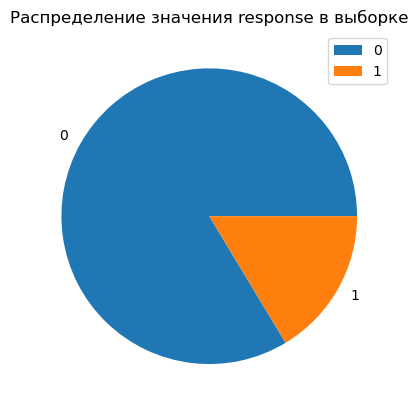

In [7]:
build_response_graph(class_train[class_result])

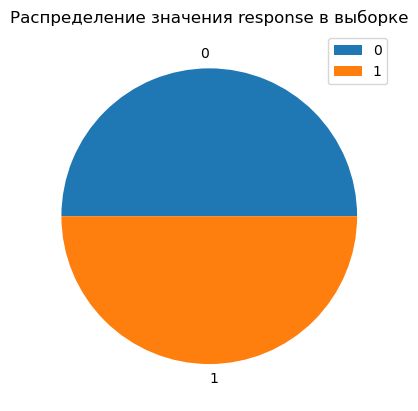

In [8]:
x = class_train[class_all]
y = class_train[class_result]
x, y = KMeansSMOTE(cluster_balance_threshold=0.3).fit_resample(x, y)
build_response_graph(y)

Разобьём выборки на train и test

In [9]:
x_train_c, x_test_c, y_train_c, y_test_c = train_test_split(x, y, test_size=0.3, random_state=7)
x = regression_train[regression_all]
y = regression_train[regression_result]
x_train_r, x_test_r, y_train_r, y_test_r = train_test_split(x, y, test_size=0.3, random_state=7)

## Построение деревьев решений

In [10]:
def create_model(params, is_regression=False):
    if is_regression:
        model = DecisionTreeRegressor(**params)
        model.fit(x_train_r, y_train_r)
        score = model.score(x_test_r, y_test_r)
    else:
        model = DecisionTreeClassifier(**params)
        model.fit(x_train_c, y_train_c)
        score = model.score(x_test_c, y_test_c)
    print(f"Model: {model}")
    print("Accuracy:", round(score, 3))
    return model

In [11]:
def build_grid(params, x_train, y_train, is_regression):
    if not is_regression:
        tree = DecisionTreeClassifier()
    else:
        tree = DecisionTreeRegressor()
    grid = GridSearchCV(tree, params, scoring='roc_auc')
    grid.fit(x_train, y_train)
    print(f"The best model: {grid.best_estimator_}")
    print("Accuracy:", round(grid.best_score_, 3))
    cross_val_score = grid.cv_results_["mean_test_score"]
    return cross_val_score, grid.best_params_

In [19]:
def test_parameters(parameters, x_train, y_train, x_test, y_test, is_regression=False):
    """
    Отбирает лучшие параметры модели классификации
    :param parameters: список тестируемых параметров
    :return: Модель с лучшими параметрами
    """
    train_acc = []
    test_acc = []
    clfs = []
    parameter_name = next(iter(parameters.keys()))
    for parameter in parameters[parameter_name]:
        value = {parameter_name: parameter}
        if is_regression:
            clf = DecisionTreeRegressor(**value)
        else:
            clf = DecisionTreeClassifier(**value)
        clfs.append(clf)
        clf.fit(x_train, y_train)
        if not is_regression:
            y_pred_train = clf.predict(x_train)
            y_pred_test = clf.predict(x_test)
            train_acc.append(accuracy_score(y_train, y_pred_train))
            test_acc.append(accuracy_score(y_test, y_pred_test))
        else:
            train_acc.append(clf.score(x_train, y_train))
            test_acc.append(clf.score(x_test, y_test))
    cross_val_acc, best_param = build_grid(parameters, x_train, y_train, is_regression)
    if parameter_name != "criterion":
        plot_accuracy_graph(parameters[parameter_name], parameter_name, train_acc, test_acc, regression=is_regression)
    else:
        plot_criteria(parameters[parameter_name], train_acc, test_acc)
    return best_param[parameter_name]

In [14]:
def plot_criteria(parameters, train_acc, test_acc, cross_acc=None):
    """
    Выводит столбчатую диаграмму критериев
    :param parameters:
    :param train_acc:
    :param test_acc:
    :param cross_acc:
    :return:
    """
    plt.bar(parameters, train_acc, label="train")
    plt.bar(parameters, test_acc, label="test")
    if cross_acc:
        plt.bar(parameters, cross_acc, label="cross validation")
    plt.legend()
    plt.show()

In [15]:
def plot_tree_image(data, features, file_name):
    """
    Визуализирует дерево и сохраняет его в виде изображения
    :param data: модель для визуализации
    :param features: набор признаков для визуализации
    :param file_name: название файла для сохранения
    """
    dot_data = StringIO()
    export_graphviz(data, out_file=dot_data, filled=True, rounded=True,
                special_characters=True, feature_names=features, class_names=['0', '1'])
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    graph.write_png(file_name)
    img = Image(graph.create_png())
    display(img)

In [16]:
def plot_accuracy_graph(parameters, parameter_name, train_acc, test_acc,
                        cross_acc=None, regression=False):
    """
    Строит график зависимости точности от параметров модели
    :param parameters: список параметров
    :param parameter_name: название исследуемого параметра
    :param train_acc: производительность на тренировочной выборке
    :param test_acc: производительность на тестовой выборке
    :param cross_acc: производительность при перекрёстной проверке
    :param regression: используем ли модель регрессии
    """
    plt.plot(parameters, train_acc, label="Train")
    plt.plot(parameters, test_acc, label="Test")
    if cross_acc:
        plt.plot(parameters, cross_acc, label="Cross validation")
    plt.xlabel(parameter_name)
    if not regression:
        plt.ylabel("Accuracy")
        plt.title(f"Accuracy vs {parameter_name}")
    else:
        plt.ylabel("R^2")
        plt.title(f"R^2 vs {parameter_name}")
    plt.legend()
    plt.show()

### Классификация

In [17]:
best_parameters = dict()

Исследуем зависимость между высотой и предсказательной способностью дерева

The best model: DecisionTreeClassifier(criterion='log_loss')
Accuracy: 0.885


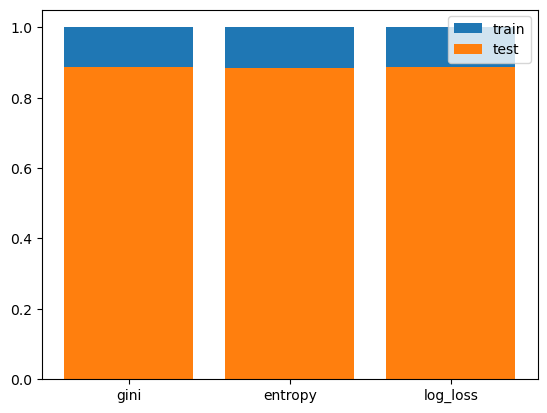

In [18]:
params = {
    "criterion": ["gini", "entropy", "log_loss"]
}
best_parameters["criterion"] = test_parameters(params, x_train_c, y_train_c, x_test_c, y_test_c)

The best model: DecisionTreeClassifier(max_leaf_nodes=29)
Accuracy: 0.966


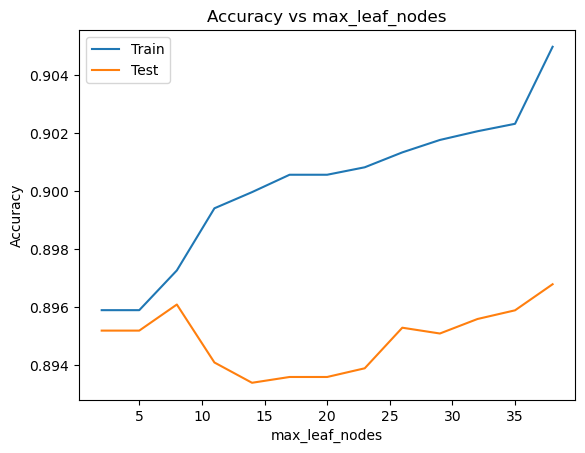

In [19]:
params = {
    "max_leaf_nodes": range(2, 40, 3),
}
best_parameters["max_leaf_nodes"] = test_parameters(params, x_train_c, y_train_c, x_test_c, y_test_c)

The best model: DecisionTreeClassifier(max_depth=5)
Accuracy: 0.965


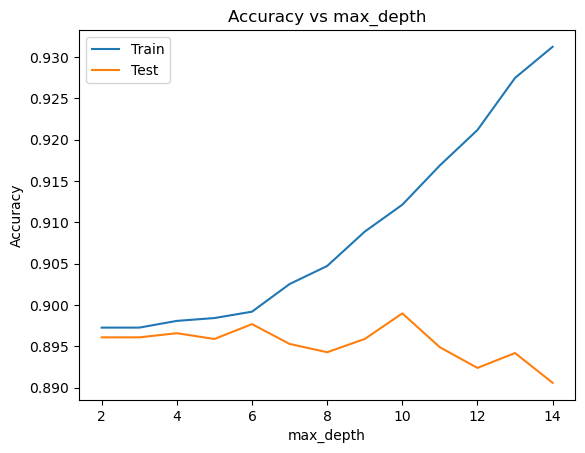

In [20]:
params = {
    "max_depth": range(2, 15)
}
best_parameters["max_depth"] = test_parameters(params, x_train_c, y_train_c, x_test_c, y_test_c)

The best model: DecisionTreeClassifier(min_samples_split=47)
Accuracy: 0.956


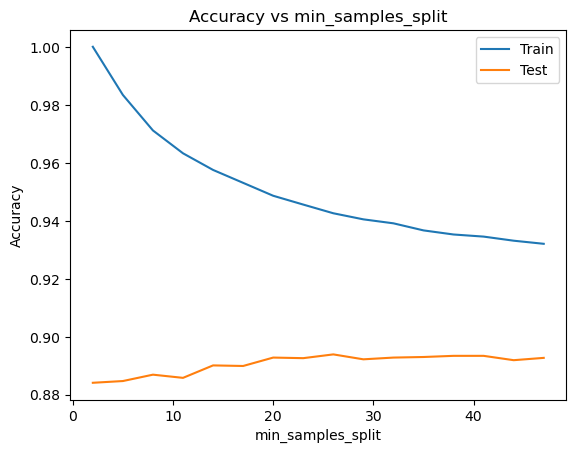

In [21]:
params = {
    "min_samples_split": range(2, 50, 3)
}
best_parameters["min_samples_split"] = test_parameters(params, x_train_c, y_train_c, x_test_c, y_test_c)

The best model: DecisionTreeClassifier(min_samples_leaf=47)
Accuracy: 0.969


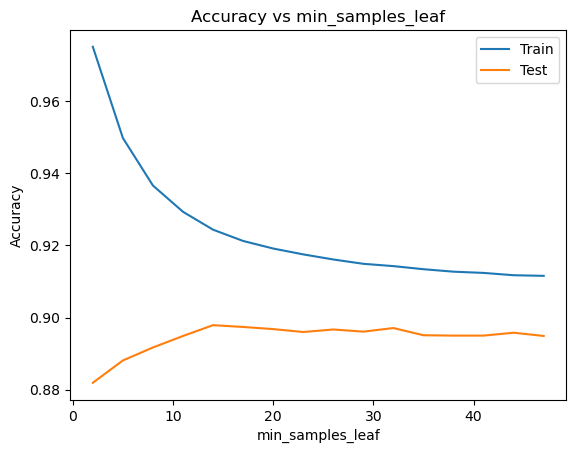

In [22]:
params = {
    "min_samples_leaf": range(2, 50, 3)
}
best_parameters["min_samples_leaf"] = test_parameters(params, x_train_c, y_train_c, x_test_c, y_test_c)

In [23]:
print(best_parameters)

{'criterion': 'log_loss', 'max_leaf_nodes': 29, 'max_depth': 5, 'min_samples_split': 47, 'min_samples_leaf': 47}


Построим дерево с наилучшими параметрами

Model: DecisionTreeClassifier(criterion='log_loss', max_depth=5, max_leaf_nodes=29,
                       min_samples_leaf=47, min_samples_split=47)
Accuracy: 0.895


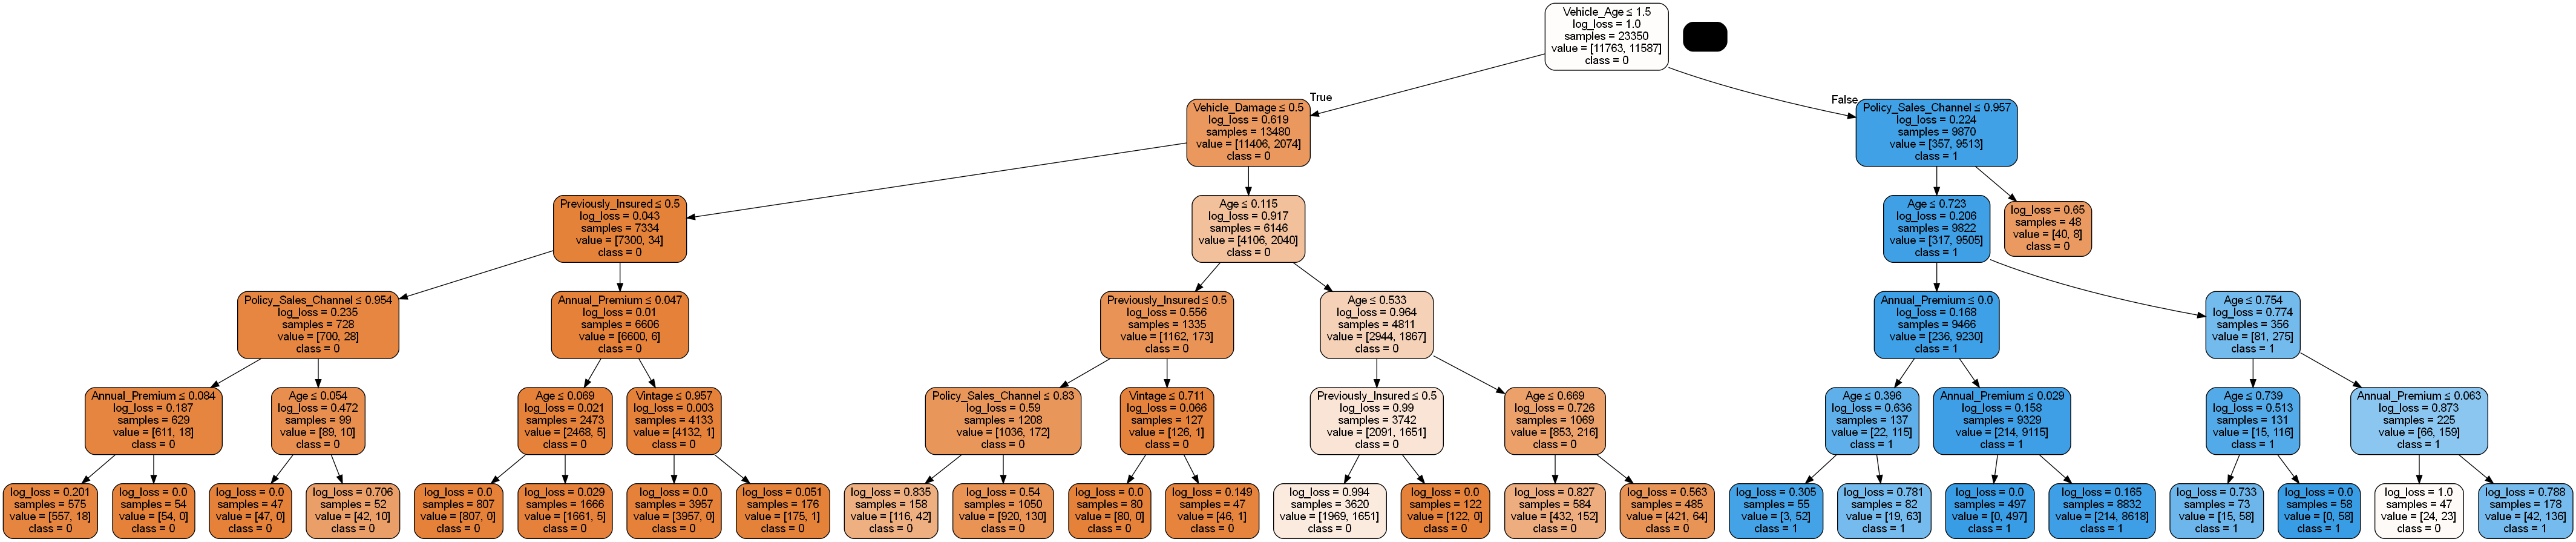

In [24]:
model = create_model(best_parameters)
plot_tree_image(model, class_all, "class_tree.png")

### Регрессия
Определим зависимость качества прогнозирования от высоты дерева

The best model: DecisionTreeRegressor(criterion='poisson')
Accuracy: nan


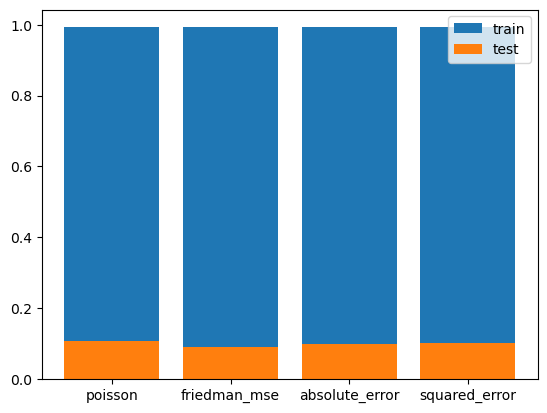

In [17]:
best_parameters = dict()
params = {
    "criterion": ["poisson", "friedman_mse", "absolute_error", "squared_error"]
}
best_parameters["criterion"] = test_parameters(params, x_train_r, y_train_r, x_test_r, y_test_r, is_regression=True)

The best model: DecisionTreeRegressor(max_leaf_nodes=2)
Accuracy: nan


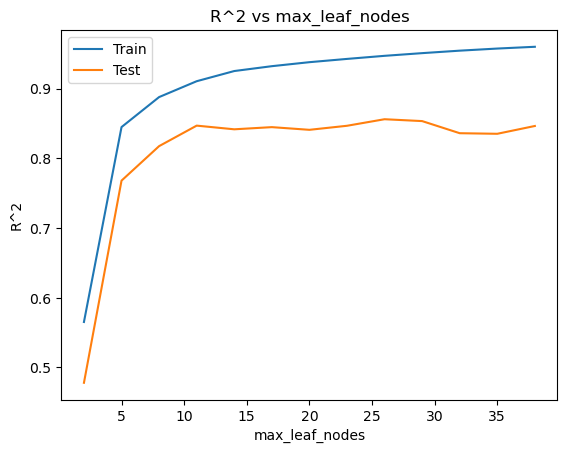

In [20]:
params = {
    "max_leaf_nodes": range(2, 40, 3)
}
best_parameters["max_leaf_nodes"] = test_parameters(params, x_train_r, y_train_r, x_test_r, y_test_r, is_regression=True)

The best model: DecisionTreeRegressor(max_depth=2)
Accuracy: nan


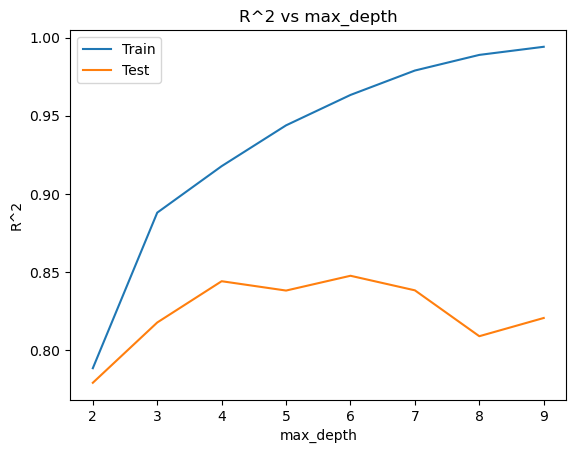

In [23]:
params = {
    "max_depth": range(2, 10)
}
best_parameters["max_depth"] = test_parameters(params, x_train_r, y_train_r, x_test_r, y_test_r, is_regression=True)

The best model: DecisionTreeRegressor()
Accuracy: nan


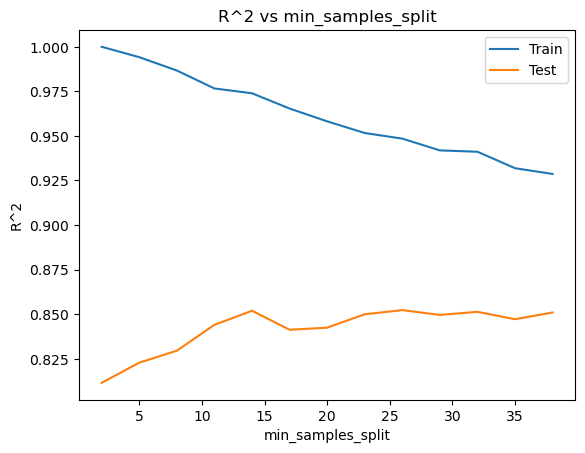

In [24]:
params = {
    "min_samples_split": range(2, 40, 3)
}
best_parameters["min_samples_split"] = test_parameters(params, x_train_r, y_train_r, x_test_r, y_test_r, is_regression=True)

The best model: DecisionTreeRegressor(min_samples_leaf=2)
Accuracy: nan


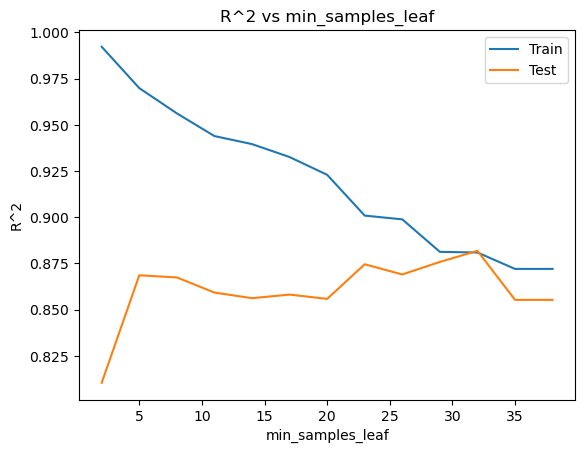

In [25]:
params = {
    "min_samples_leaf": range(2, 40, 3)
}
best_parameters["min_samples_leaf"] = test_parameters(params, x_train_r, y_train_r, x_test_r, y_test_r, is_regression=True)

Построим дерево с наилучшими параметрами

Model: DecisionTreeRegressor(criterion='friedman_mse', max_depth=4, max_leaf_nodes=26,
                      min_samples_leaf=32, min_samples_split=26)
Accuracy: 0.88


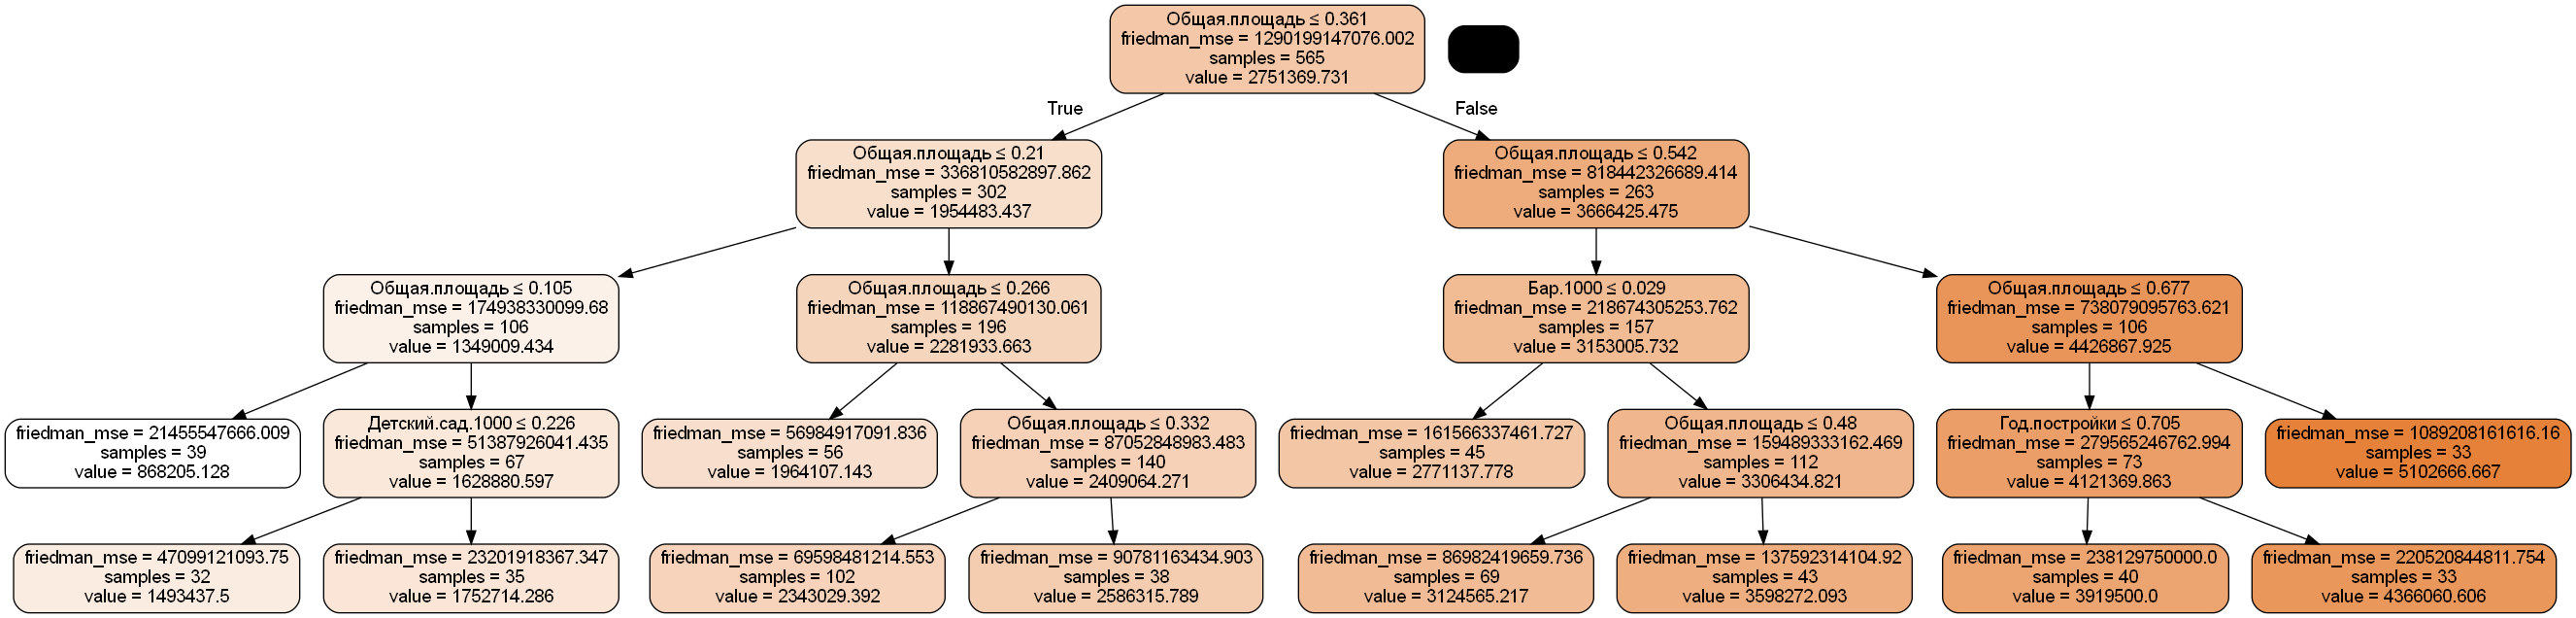

In [32]:
model = create_model(best_parameters, is_regression=True)
plot_tree_image(model, regression_all, "regression_tree.png")

## Обрезка деревьев
### Классификация
Выберем лучшее значение ccp_alphas

In [ ]:
dt = DecisionTreeClassifier(criterion="entropy", max_depth=5)
path = dt.cost_complexity_pruning_path(x_train_c, y_train_c)
ccp_alphas = path.ccp_alphas
model = test_class_parameters(ccp_alphas, 0)

Построим обрезанное дерево

In [ ]:
plot_tree_image(model, class_all, "new_class.png")

### Регрессия
Выберем лучшее значение ccp_alphas

In [ ]:
dt = DecisionTreeRegressor(max_depth=5)
path = dt.cost_complexity_pruning_path(x_train_r, y_train_r)
ccp_alphas = path.ccp_alphas
model = test_regression_parameters(ccp_alphas, 0)

Построим обрезанное дерево

In [ ]:
plot_tree_image(model, regression_all, "new_regression.png")

Можно увидеть, что обрезка дерева приводит к увеличению score для тестовой выборки

## Сравнение результатов
Скопируем данные из прошлых практических работ

In [ ]:
class_models =  pd.DataFrame(
    {
        "Model name": ["LogisticRegression", "KNeighborsClassifier", "GaussianNB", "LinearDiscriminantAnalysis",
                         "QuadraticDiscriminantAnalysis", "SVC"],
        "Score": [0.923, 0.951, 0.938, 0.922, 0.937, 0.929],
    }
)

In [ ]:
regression_models = pd.DataFrame(
    {
        "Model name": ["Линейная регрессия", "Лассо регрессия", "Гребневая регрессия", "Elastic-Net", "Метод наименьших углов",
                       "Байесовская регрессия", "Обобщённая линейная регрессия", "Взвешенный МНК", "Полиномиальная регрессия",
                       "Непараметрическая регрессия", "Ядерная регрессия"],
        "R^2": [0.892566, 0.891590, 0.891587, 0.885632, 0.892566, 0.891779, 0.874363, 0.875718, 0.893461, 0.716178, 0.897392],
    }
)

Добавим результаты, полученные с помощью деревьев решений

Построим столбчатые диаграммы

In [ ]:
def plot_bar_graph(ax, names, scoring, title):
    """
    Строит столбчатую диаграмму для score моделей
    :param ax: ось, на которой строим график
    """
    ax.bar(names, scoring)
    ax.set_title(title)
    ax.tick_params("x", labelrotation=90)
    ax.set_ylim((0.5, 1))
    ax.yaxis.set_major_locator(MultipleLocator(0.05))
    ax.yaxis.set_minor_locator(MultipleLocator(0.01))
    for rect, score in zip(ax.patches, scoring):
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_height() + 0.01, score, ha="center")
    ax.set_xlabel("Model", labelpad=15)
    ax.set_ylabel("Score", labelpad=15)

In [ ]:
def compare_models():
    """
    Выводит графики для сравнения моделей
    @:return:
    """
    fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(25, 7))
    fig.subplots_adjust(hspace=0.4)
    plot_bar_graph(axs[0], regression_models["Model name"], regression_models["R^2"], "Regression")
    plot_bar_graph(axs[1], class_models["Model name"], class_models["Score"], "Classification")

In [ ]:
compare_models()